# 10. MNIST with MLP

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf

import keras_tuner as kt
from keras_tuner import HyperParameters, RandomSearch, HyperModel, BayesianOptimization

from keras.api.datasets import mnist
from keras import Sequential
from keras.api.layers import Input, Dense, Flatten, Normalization
from keras.api.optimizers import Adam, SGD
from keras.api.callbacks import EarlyStopping, Callback, TensorBoard, ModelCheckpoint

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from time import strftime

RANDOM_STATE = 42

2025-02-07 09:31:18.426691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738917078.445490   13573 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738917078.451833   13573 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

## Scikit's MLPClassifier

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10_000, random_state=RANDOM_STATE
)

In [4]:
assert x_train.shape == (50000, 28, 28)
assert x_valid.shape == (10000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (50000,)
assert y_valid.shape == (10000,)
assert y_test.shape == (10000,)

In [5]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

In [6]:
x_train.shape
x_valid.shape
x_test.shape

(10000, 784)

In [7]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=300).fit(x_train, y_train)

In [8]:
y_pred_test = clf.predict(x_test)

In [9]:
accuracy_score(y_test, y_pred_test)

0.9586

Scale data (0-1)

In [10]:
x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0

In [11]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=300).fit(x_train, y_train)
y_pred_test = clf.predict(x_test)
accuracy_score(y_test, y_pred_test)

/home/martin/miniconda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9638

In [45]:
parameter_space = {
    "hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (100,), (100, 50)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.001, 0.05, 0.10],
    "learning_rate": ["constant", "adaptive"],
}

mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=300)

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train[:15000], y_train[:15000])

/home/martin/miniconda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/martin/miniconda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/martin/miniconda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/martin/miniconda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/martin/miniconda/lib/python3.1

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=300, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.05, 0.1],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,), (100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [51]:
print("Best parameters found:\n", clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

In [47]:
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.942 (+/-0.008) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.945 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.942 (+/-0.008) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.945 (+/-0.005) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.941 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.947 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.941 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 

In [48]:
y_true, y_pred = y_valid, clf.predict(x_valid)

from sklearn.metrics import classification_report

print("Results on the test set:")
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       984
           1       0.98      0.99      0.98      1093
           2       0.97      0.96      0.97       994
           3       0.97      0.96      0.96      1000
           4       0.96      0.98      0.97       980
           5       0.96      0.96      0.96       919
           6       0.97      0.98      0.98       981
           7       0.97      0.98      0.98      1060
           8       0.97      0.93      0.95       979
           9       0.95      0.96      0.96      1010

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [49]:
y_pred_test = clf.predict(x_test)
accuracy_score(y_test, y_pred_test)

0.9669

In [50]:
best_mlp = MLPClassifier(**clf.best_params_)
best_mlp.fit(x_train, y_train)
y_pred_test = best_mlp.predict(x_test)
accuracy_score(y_test, y_pred_test)

0.9808

## Tensorflow / Keras

In [3]:
tf.keras.backend.clear_session()
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [4]:
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, test_size=10_000, random_state=RANDOM_STATE
)

In [5]:
# Normalize so we work with range of 0 to 1 and convert to float
x_train_full, x_train, x_valid, x_test = map(
    lambda x: x / 255.0, (x_train_full, x_train, x_valid, x_test)
)

In [6]:
# Extract input shape of input data (shape of each instance)
input_shape = np.shape(x_train_full)[1:]
input_shape

(28, 28)

In [8]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

I0000 00:00:1738915161.468226    1003 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 509,410 (1.94 MB)

 Trainable params: 509,410 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
class ExponentialLearningRate(Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [11]:
expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(
    x_train,
    y_train,
    epochs=1,
    validation_data=(x_valid, y_valid),
    callbacks=[expon_lr],
)

I0000 00:00:1738915174.373794    2274 service.cc:148] XLA service 0x7feadc007930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738915174.374322    2274 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-02-07 08:59:34.433945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738915174.621628    2274 cuda_dnn.cc:529] Loaded cuDNN version 90700


  36/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4489 - loss: 1.7006

I0000 00:00:1738915176.142125    2274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6351 - loss: 1.1486 - val_accuracy: 0.0984 - val_loss: 2.5051


Text(0, 0.5, 'Loss')

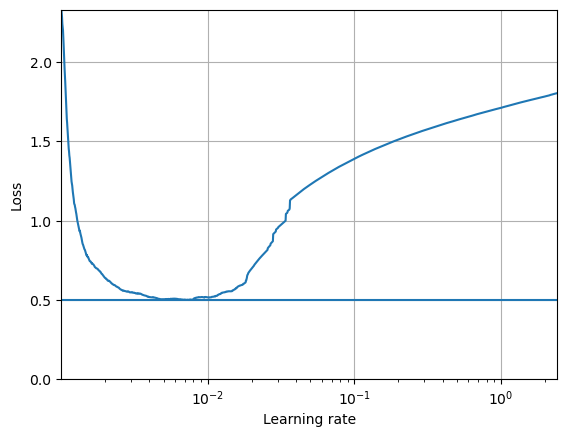

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [9]:
history = model.fit(
    x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid)
)

Epoch 1/100


I0000 00:00:1738872771.262450    4664 service.cc:148] XLA service 0x7f36fc0067c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738872771.262507    4664 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-02-06 21:12:51.294251: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738872771.473339    4664 cuda_dnn.cc:529] Loaded cuDNN version 90700


  70/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5824 - loss: 1.3090

I0000 00:00:1738872772.999749    4664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8885 - loss: 0.3627 - val_accuracy: 0.9595 - val_loss: 0.1332
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9670 - loss: 0.1089 - val_accuracy: 0.9648 - val_loss: 0.1176
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9764 - loss: 0.0743 - val_accuracy: 0.9700 - val_loss: 0.1120
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9828 - loss: 0.0551 - val_accuracy: 0.9732 - val_loss: 0.1026
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9859 - loss: 0.0470 - val_accuracy: 0.9732 - val_loss: 0.1056
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9874 - loss: 0.0402 - val_accuracy: 0.9742 - val_loss: 0.1060
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9896 - loss: 0.0308 - val_accuracy: 0.9776 - val_loss: 0.1033
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9922 - loss: 0.0286 - val_

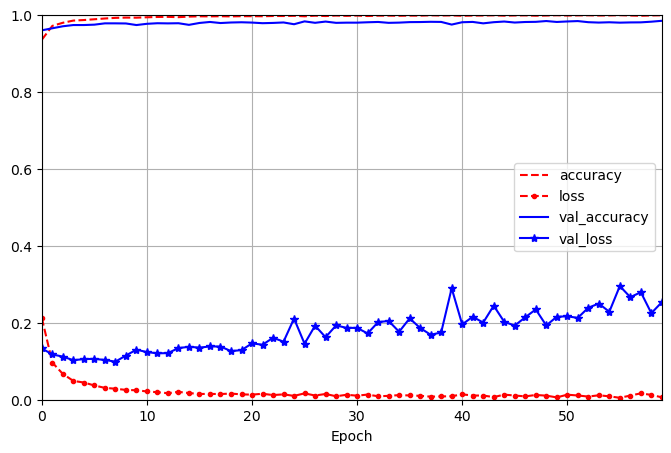

In [10]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 59],
    ylim=[0, 1],
    grid=True,
    xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.show()

Difference between train and validation accurracy points to overfitting. Constant increase in validation loss is another sign.

In [11]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9791 - loss: 0.4660
test loss, test acc: [0.3696935474872589, 0.9822999835014343]


## Manual DNN hyperparameter tuning

In [7]:
def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")


run_logdir = get_run_logdir()
run_logdir

PosixPath('my_logs/run_2025_02_07_09_31_48')

In [14]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(300, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 509,410 (1.94 MB)

 Trainable params: 509,410 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [29]:
class PrintValTrainRatioCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")
        return super().on_epoch_end(epoch, logs)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[
        EarlyStopping(patience=20, restore_best_weights=True),
        PrintValTrainRatioCallback(),
        TensorBoard(get_run_logdir()),
        ModelCheckpoint("my_checkpoints/checkpoint.weights.h5", save_weights_only=True),
    ],
)

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8799 - loss: 0.3829Epoch=0, val/train=0.61
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8800 - loss: 0.3828 - val_accuracy: 0.9591 - val_loss: 0.1372
Epoch 2/100
1557/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9650 - loss: 0.1171Epoch=1, val/train=1.06
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9650 - loss: 0.1171 - val_accuracy: 0.9683 - val_loss: 0.1132
Epoch 3/100
1557/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9767 - loss: 0.0806Epoch=2, val/train=1.63
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9767 - loss: 0.0806 - val_accuracy: 0.9677 - val_loss: 0.1210
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9805 - loss: 0.0652Epoch=3, val/train=1.69
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9805 - loss: 0.0652 - val_accuracy: 0.9722 - val_loss: 0.1011
Epoch 5/100
1560/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831

In [203]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9735 - loss: 0.1167
test loss, test acc: [0.09471593052148819, 0.9782999753952026]


Test loss is smaller but accuracy dropped as well.

Higher learning rate (0.002) performs worse.

More neurons and layers seems to be better (higher accuracy).

Less neurons and layers doesn't lower overfitting.

98% accuracy on test set achieved by adding another hidden layer (4).

## Hyper-Tuner

In [15]:
def build_model(hp: HyperParameters) -> Sequential:
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=8, default=4)
    n_neurons = hp.Int("n_neurons", min_value=128, max_value=512)
    learning_rate = hp.Float(
        "learning_rate", min_value=1e-3, max_value=1e-2, sampling="log"
    )
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()
    model.add(Flatten())
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model

In [16]:
class MyClassificationHyperModel(HyperModel):

    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = Normalization()
            X = norm_layer(X)
        batch_size = hp.Int("batch_size", min_value=16, max_value=128, default=32, step=16)
        return model.fit(X, y, batch_size=batch_size, **kwargs)

In [ ]:
random_search_tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    seed=RANDOM_STATE,
    overwrite=True,
    directory="my_mnist",
    project_name="my_rnd_search",
)
random_search_tuner.search(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[EarlyStopping(patience=2), TensorBoard(get_run_logdir())],
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
5                 |5                 |n_hidden
25                |25                |n_neurons
0.00065625        |0.00065625        |learning_rate
sgd               |sgd               |optimizer

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1098 - loss: 2.3106 - val_accuracy: 0.1497 - val_loss: 2.2797
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1697 - loss: 2.2695 - val_accuracy: 0.2031 - val_loss: 2.2286
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2077 - loss: 2.2095 - val_accuracy: 0.2404 - val_loss: 2.1426
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2688 - loss: 2.1172 - val_accuracy: 0.3319 - val_loss: 2.0434
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3535 - loss: 2.0130 - val_accuracy: 0.4093 - val_loss: 1.9111
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accura

In [ ]:
hyperband_tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    seed=RANDOM_STATE,
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,
    overwrite=True,
    directory="my_mnist",
    project_name="hyperband",
)

In [ ]:
hyperband_tuner.search(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[
        EarlyStopping(patience=2),
        TensorBoard(Path(hyperband_tuner.project_dir) / "tensorboard"),
    ],
)

Trial 2 Complete [00h 00m 19s]
val_accuracy: 0.43540000915527344

Best val_accuracy So Far: 0.43540000915527344
Total elapsed time: 00h 00m 41s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
5                 |8                 |n_hidden
221               |263               |n_neurons
0.0090513         |0.0012483         |learning_rate
adam              |sgd               |optimizer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8236 - loss: 0.6204 - val_accuracy: 0.9181 - val_loss: 0.3215
Epoch 2/2
 852/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9298 - loss: 0.3065

KeyboardInterrupt: 

In [ ]:
best_trial = hyperband_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 0054 summary
Hyperparameters:
n_hidden: 7
n_neurons: 159
learning_rate: 0.001989751755243559
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0052
Score: 0.9757999777793884


In [11]:
best_model = hyperband_tuner.get_best_models(num_models=1)[0]

best_model.fit(x_train_full, y_train_full)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9811 - loss: 0.0855


In [12]:
results = best_model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9687 - loss: 0.1282
test loss, test acc: [0.11546468734741211, 0.9714999794960022]


In [17]:
bayesian_opt_tuner = BayesianOptimization(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    seed=42,
    max_trials=20,
    alpha=1e-4,
    beta=2.6,
    overwrite=True,
    directory="my_mnist",
    project_name="bayesian_opt",
)
bayesian_opt_tuner.search(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[EarlyStopping(patience=2), TensorBoard(Path(bayesian_opt_tuner.project_dir) / "tensorboard")],
)

Trial 20 Complete [00h 00m 42s]
val_accuracy: 0.9679999947547913

Best val_accuracy So Far: 0.9782000184059143
Total elapsed time: 01h 36m 07s


In [18]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 07 summary
Hyperparameters:
n_hidden: 3
n_neurons: 319
learning_rate: 0.005389284745949777
optimizer: sgd
normalize: True
batch_size: 32
Score: 0.9782000184059143


Trial 02 summary
Hyperparameters:
n_hidden: 8
n_neurons: 365
learning_rate: 0.006718710759425462
optimizer: sgd
normalize: True
batch_size: 16
Score: 0.972599983215332

In [29]:
best_model = bayesian_opt_tuner.get_best_models(num_models=1)[0]

best_model.fit(x_train_full, y_train_full, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9942 - loss: 0.0247
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9952 - loss: 0.0221
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9959 - loss: 0.0199
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9964 - loss: 0.0182
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9967 - loss: 0.0167
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9972 - loss: 0.0155
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9976 - loss: 0.0143
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9979 - loss: 0.0133
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9982 - loss: 0.0124
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9985 - loss: 0.0116


In [30]:
results = best_model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9744 - loss: 0.0882
test loss, test acc: [0.07178439199924469, 0.979200005531311]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9744 - loss: 0.0878
test loss, test acc: [0.07178439199924469, 0.979200005531311]

In [21]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

Launching TensorBoard...